## Assignment

### Imports

In [2]:
import pydicom
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import polygon
from skimage import measure
import plotly.graph_objects as go
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.patches as mpatches
from scipy.interpolate import RegularGridInterpolator

### Functions

In [3]:
def mm_to_voxel(mm_coords, origin, spacing):
    return np.round((mm_coords-origin)/spacing).astype(int)

### Read all files

In [4]:
# Folder = Path(f"{Path().resolve()}/Tractography_3")

Folder = Path("V:/Common/Staff Personal Folders/DanielH/DICOM_Files/Introduction/Tractography_3")
CT_File_Names = []
RD_File_Names = []
RP_File_Names = []
RS_File_Names = []
MR_File_Names = []

CT_Files = []
RD_Files = []
RP_Files = []
RS_Files = []
MR_Files = []

for file in Folder.glob("*.dcm"):
    if file.is_file():
        # print(f"Found file: {file.name}")
        try:
            if "CT" in file.name.upper() and pydicom.dcmread(file, stop_before_pixels=True).Modality == 'CT':
                CT_Files.append(pydicom.dcmread(file)) 
                CT_File_Names.append(file)
            elif "RD" in file.name.upper() and pydicom.dcmread(file, stop_before_pixels=True).Modality == 'RTDOSE':
                RD_Files.append(pydicom.dcmread(file))
                RD_File_Names.append(file)
            elif "RP" in file.name.upper() and pydicom.dcmread(file, stop_before_pixels=True).Modality == 'RTPLAN':
                RP_Files.append(pydicom.dcmread(file))
                RP_File_Names.append(file)
            elif "RS" in file.name.upper() and pydicom.dcmread(file, stop_before_pixels=True).Modality == 'RTSTRUCT':
                RS_Files.append(pydicom.dcmread(file))
                RS_File_Names.append(file)
            elif "MR" in file.name.upper() and pydicom.dcmread(file, stop_before_pixels=True).Modality == 'MR':
                MR_Files.append(pydicom.dcmread(file))
                MR_File_Names.append(file)
            else:
                print(f"Unknown DICOM file {file.name}")
        except:
            print(f"Skipped invalid DICOM: {file.name}")

print(f"Found {len(CT_Files)+len(RD_Files)+len(RP_Files)+len(RS_Files)+len(MR_Files)} valid DICOM files")

Unknown DICOM file REG1.2.752.243.1.1.20250414083105220.2300.47522.dcm
Unknown DICOM file REG1.2.752.243.1.1.20250414083105222.2400.60573.dcm
Found 968 valid DICOM files


### Plot gantry position as function of control point

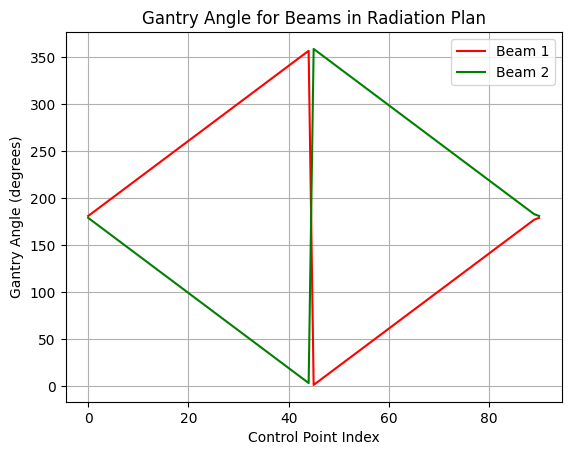

In [38]:
Beams = [beam for beam in RP_Files[0].BeamSequence # only 1 radiation plan file
         if beam.TreatmentDeliveryType.upper() == "TREATMENT"] # only consider treatment beams

gantry_angles = np.full((len(Beams), len(Beams[0].ControlPointSequence)), np.nan) # pre-allocating

for i, beam in enumerate(Beams):
    for j, controlpoint in enumerate(beam.ControlPointSequence):
        try:
            gantry_angles[i, j] = controlpoint.GantryAngle
        except:
            print(f"Skipped gantry angle for beam {i} control point {j}")

colours = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'white']

for i in range(np.shape(gantry_angles)[0]):
    plt.plot(gantry_angles[i], label=f"Beam {i+1}", color = colours[i])

plt.legend()
plt.xlabel("Control Point Index")
plt.ylabel("Gantry Angle (degrees)")
plt.title("Gantry Angle for Beams in Radiation Plan")
plt.grid(True)
plt.show()

### Plot 2D view of MLCs (Multi-Leaf Collimators) for one control point

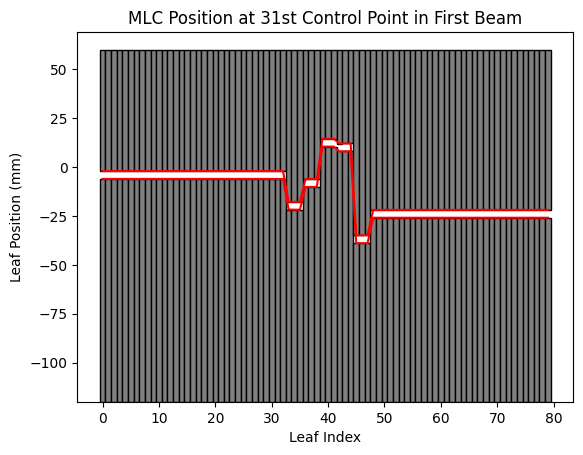

In [39]:
Beams = [beam for beam in RP_Files[0].BeamSequence # only 1 radiation plan file
         if beam.TreatmentDeliveryType.upper() == "TREATMENT"] # only consider treatment beams

beam = Beams[0] # only looking at beam 1 for now

controlpoint = beam.ControlPointSequence[30] # only looking at one control point for now

for device in controlpoint.BeamLimitingDevicePositionSequence:
    if device.RTBeamLimitingDeviceType == "MLCX":
        MLC_positons = device.LeafJawPositions
        MLC_DOWN = MLC_positons[:len(MLC_positons)//2]
        MLC_UP = MLC_positons[len(MLC_positons)//2:]
        plt.plot(MLC_DOWN, color = 'red')
        plt.plot(MLC_UP, color = 'red')
        min_height = -120
        plt.bar(np.arange(len(MLC_DOWN)), height = [leaf - min_height for leaf in MLC_DOWN], width=1.0, bottom=min_height, color='grey', edgecolor = 'black')
        max_height = 60
        plt.bar(np.arange(len(MLC_UP)), height = [max_height - leaf for leaf in MLC_UP], width=1.0, bottom = MLC_UP, color = 'grey', edgecolor = 'black')
        plt.xlabel('Leaf Index')
        plt.ylabel('Leaf Position (mm)')
        plt.title(f"MLC Position at 31st Control Point in First Beam")
        plt.show()


### Plot the MUs as a function of control point

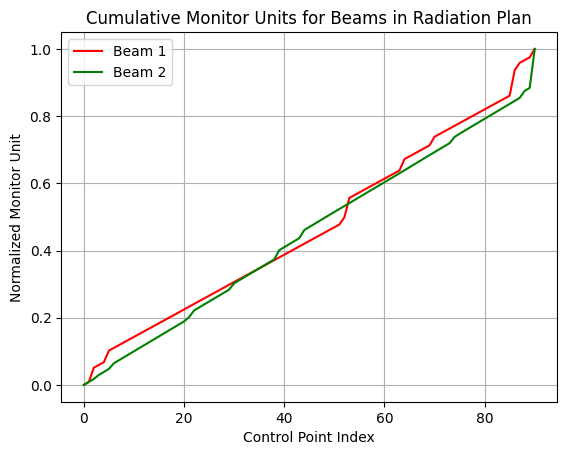

In [40]:
Beams = [beam for beam in RP_Files[0].BeamSequence # only 1 radiation plan file
         if beam.TreatmentDeliveryType.upper() == "TREATMENT"] # only consider treatment beams

monitor_units = np.full((len(Beams), len(Beams[0].ControlPointSequence)), np.nan) # pre-allocating

for i, beam in enumerate(Beams):
    for j, controlpoint in enumerate(beam.ControlPointSequence):
        monitor_units[i, j] = controlpoint.CumulativeMetersetWeight 
        if monitor_units[i, j] == 1:
            monitor_units[i, j:] = 1
            break

colours = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black']

for i in range(np.shape(monitor_units)[0]):
    plt.plot(monitor_units[i], label=f"Beam {i+1}", color = colours[i])

plt.legend()
plt.xlabel("Control Point Index")
plt.ylabel("Normalized Monitor Unit")
plt.title("Cumulative Monitor Units for Beams in Radiation Plan")
plt.grid(True)
plt.show()

### Plot the slice at isocentre of the CT in all three planes (coronal, sagittal and axial) labeled properly

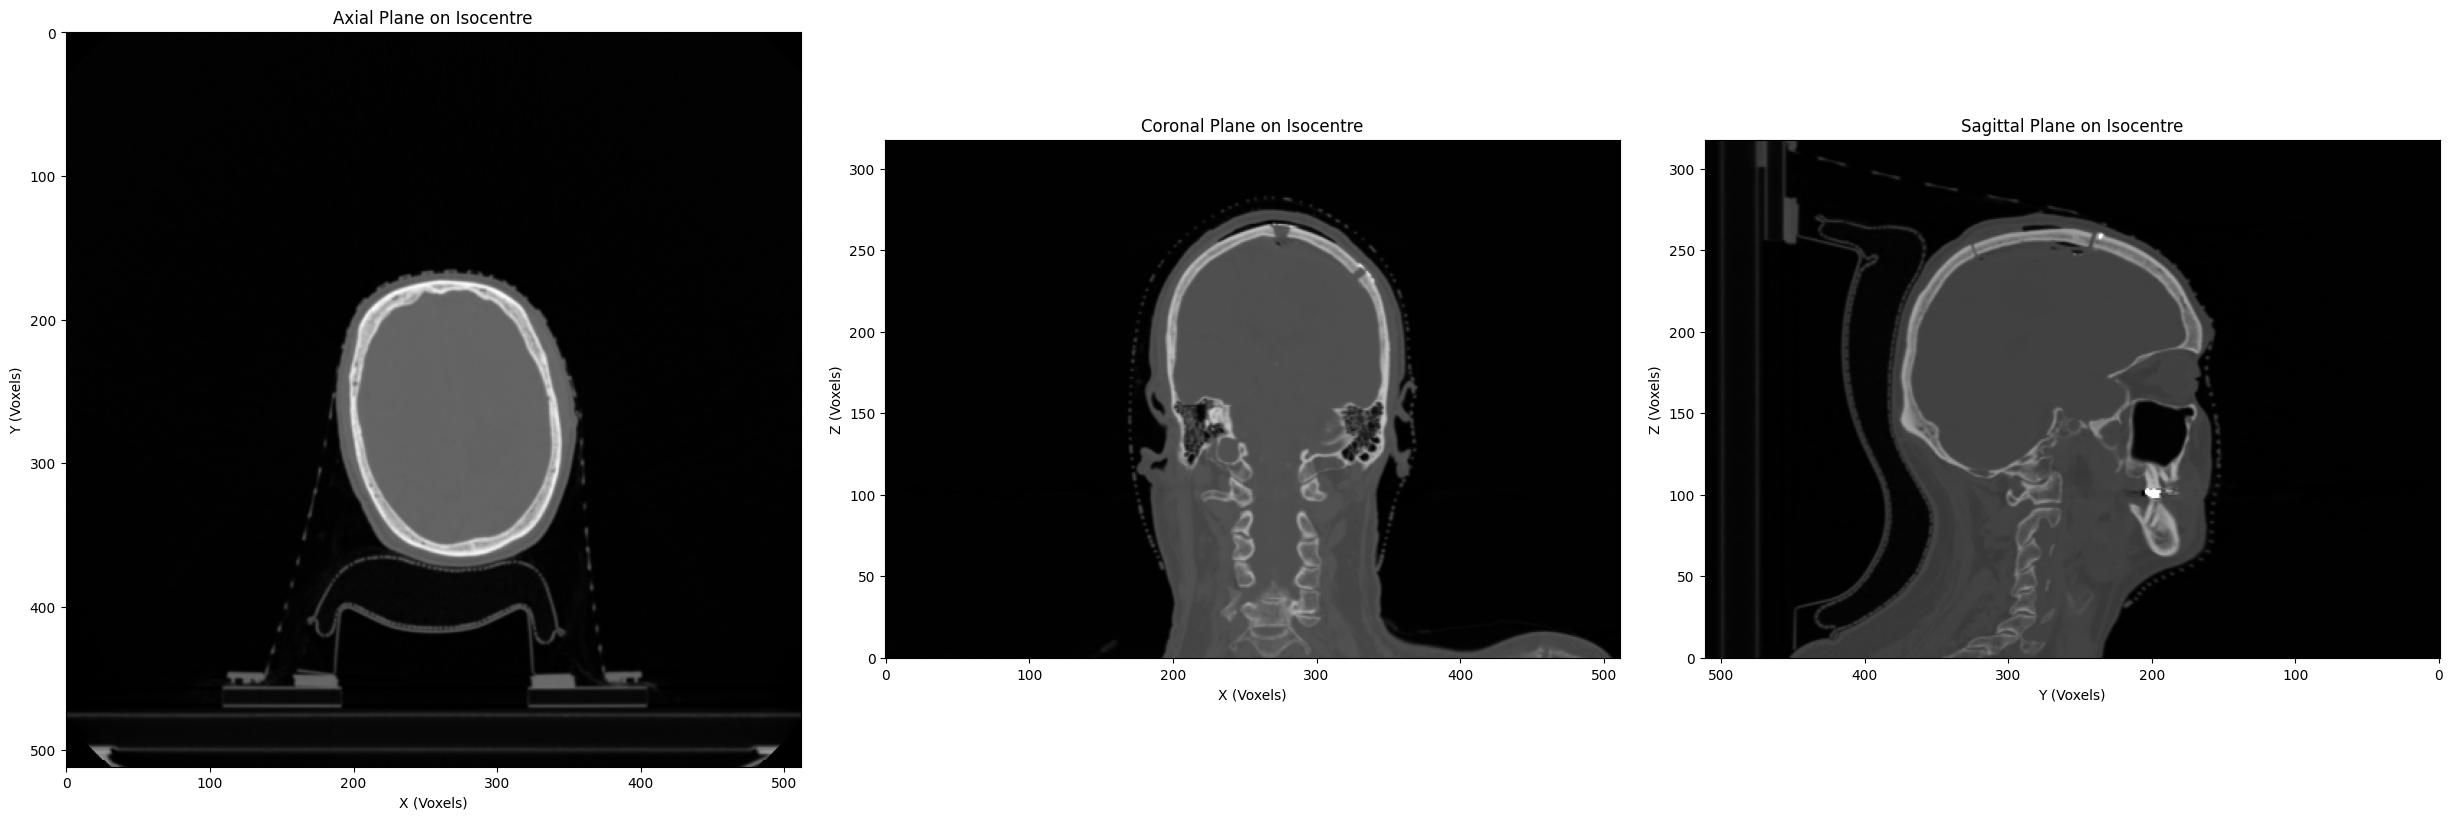

In [41]:
Sorted_CT_Files = sorted(CT_Files, key=lambda file: float(file.ImagePositionPatient[2])) # sort files by z-axis. increasing towards the head
# anatomical orientation type (0010,2210) absent so z-axis is increasing towards the head of the patient

CT_Images = np.stack([slice.pixel_array for slice in Sorted_CT_Files], axis = 2) # make 3d matrix in [y x z]
CT_Images = np.transpose(CT_Images, (1, 0, 2)) # make it [x y z]

pixel_spacing = Sorted_CT_Files[0].PixelSpacing # pixel spacing in mm, [y x]
slice_thickness = Sorted_CT_Files[0].SliceThickness # slice thickness in mm [z]
voxel_spacing = np.array([pixel_spacing[1], pixel_spacing[0], slice_thickness]) # [x y z]
origin = np.array(Sorted_CT_Files[0].ImagePositionPatient) # origin in mm [x y z]

Isocentre_Pos = np.array(RP_Files[0].BeamSequence[0].ControlPointSequence[0].IsocenterPosition) # get isocentre position in mm [x y z]
Isocentre_Pos = np.round((Isocentre_Pos - origin)/voxel_spacing).astype(int) # Convert isocentre position into voxel indices [x y z]

# Create figure and plot
fig, axs = plt.subplots(1, 3, figsize=(25,25))
plt.tight_layout(pad=3.0)

# Need to tranpose for all of them so that y-axis and x-axis are proper (i think imshow is kinda weird like that)
# Need to set origin to upper for axial to get same view as RayStation
axs[0].imshow(CT_Images[:, :, Isocentre_Pos[2]].T, origin='upper', cmap = 'grey', aspect = pixel_spacing[0]/pixel_spacing[1]) # aspect = dy/dx
axs[0].set_title('Axial Plane on Isocentre')
axs[0].set_xlabel('X (Voxels)')
axs[0].set_ylabel('Y (Voxels)')

axs[1].imshow(CT_Images[:, Isocentre_Pos[1], :].T, origin = 'lower', cmap = 'grey', aspect = slice_thickness/pixel_spacing[1]) # aspect = dz/dx
axs[1].set_title('Coronal Plane on Isocentre')
axs[1].set_xlabel('X (Voxels)')
axs[1].set_ylabel('Z (Voxels)')

axs[2].imshow(CT_Images[Isocentre_Pos[0], :, :].T, origin='lower', cmap = 'grey', aspect = slice_thickness/pixel_spacing[0]) # aspect = dz/dy
axs[2].set_title('Sagittal Plane on Isocentre')
axs[2].set_xlabel('Y (Voxels)')
axs[2].set_ylabel('Z (Voxels)')
axs[2].invert_xaxis() # Invert x-axis (which is y-axis in anatomical coordinates) to see it the same way as RayStation

### Overlay the contours of the relevant structures on the image plots

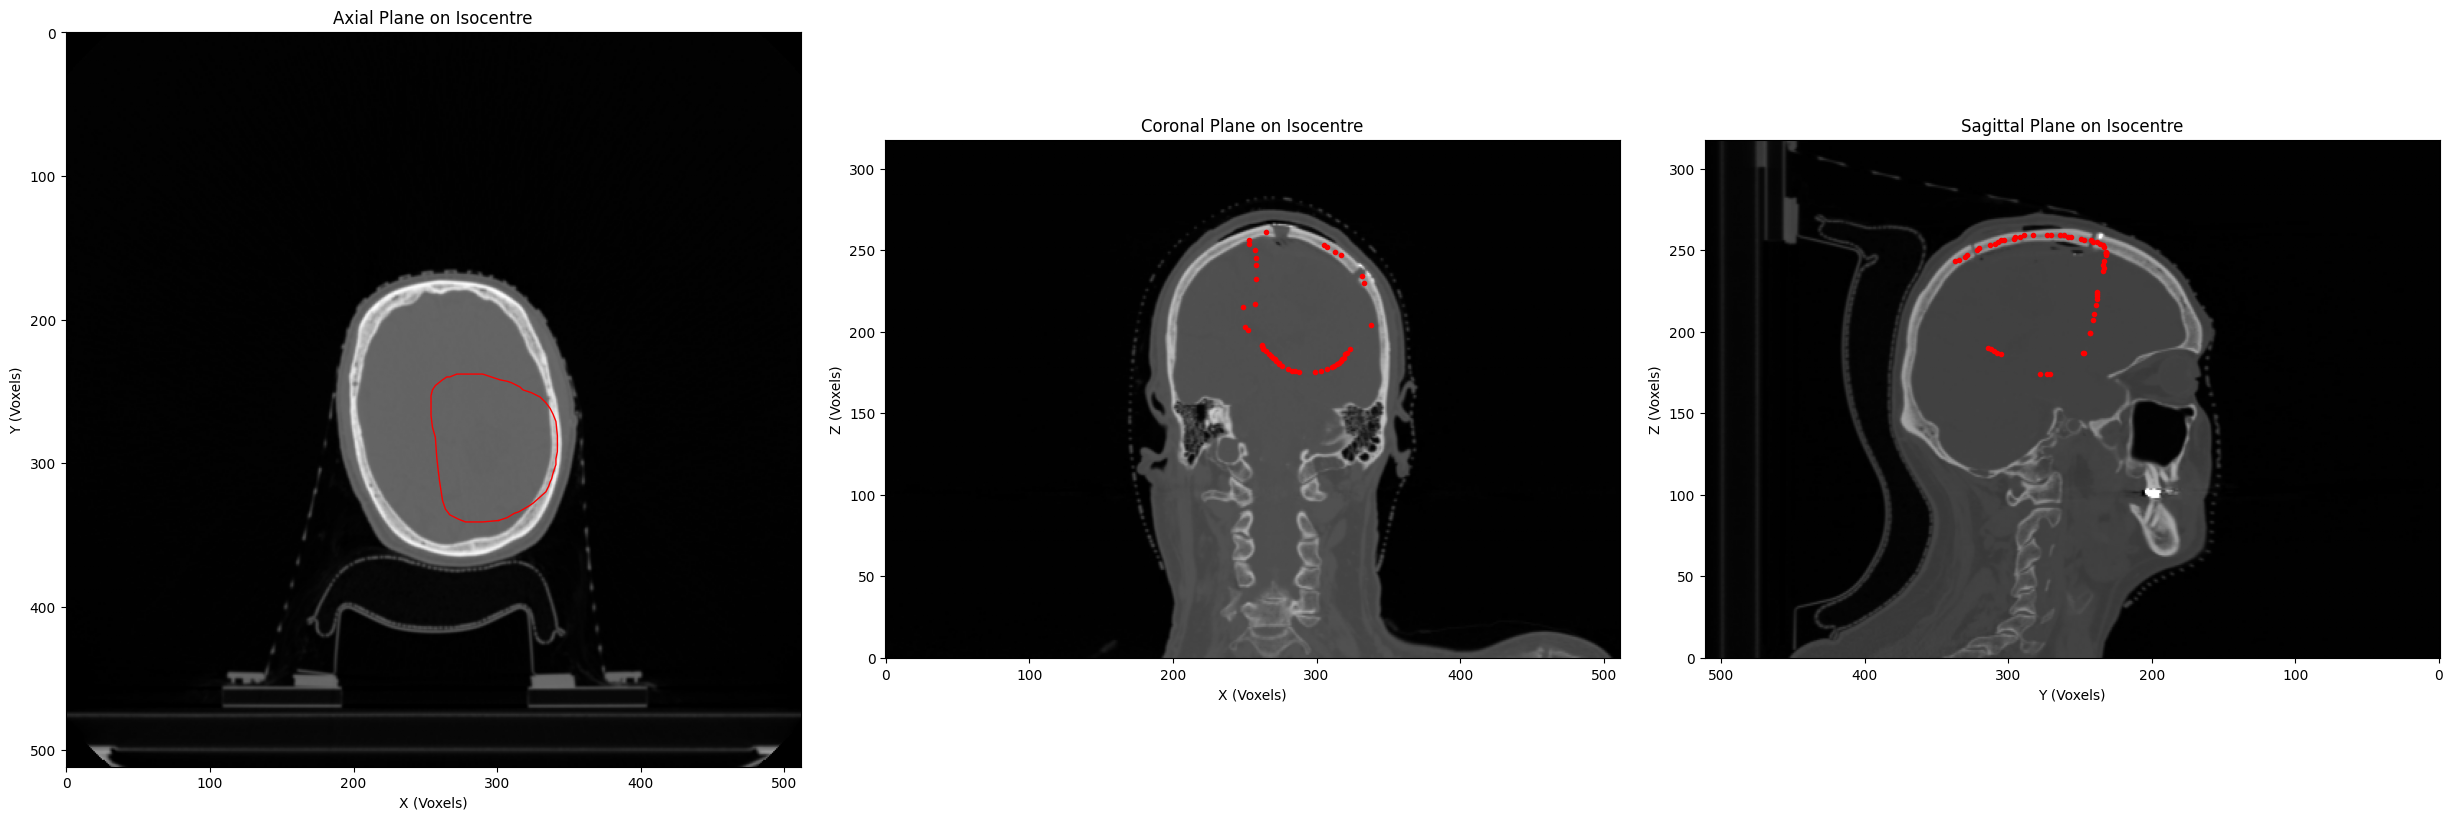

In [48]:
# plot stuff from before
# Create figure and plot
fig, axs = plt.subplots(1, 3, figsize=(25,25))
plt.tight_layout(pad=3.0)

# Need to tranpose for all of them so that y-axis and x-axis are proper (i think imshow is kinda weird like that)
# Need to set origin to upper for axial to get same view as RayStation
axs[0].imshow(CT_Images[:, :, Isocentre_Pos[2]].T, origin='upper', cmap = 'grey', aspect = pixel_spacing[0]/pixel_spacing[1]) # aspect = dy/dx
axs[0].set_title('Axial Plane on Isocentre')
axs[0].set_xlabel('X (Voxels)')
axs[0].set_ylabel('Y (Voxels)')

axs[1].imshow(CT_Images[:, Isocentre_Pos[1], :].T, origin = 'lower', cmap = 'grey', aspect = slice_thickness/pixel_spacing[1]) # aspect = dz/dx
axs[1].set_title('Coronal Plane on Isocentre')
axs[1].set_xlabel('X (Voxels)')
axs[1].set_ylabel('Z (Voxels)')

axs[2].imshow(CT_Images[Isocentre_Pos[0], :, :].T, origin='lower', cmap = 'grey', aspect = slice_thickness/pixel_spacing[0]) # aspect = dz/dy
axs[2].set_title('Sagittal Plane on Isocentre')
axs[2].set_xlabel('Y (Voxels)')
axs[2].set_ylabel('Z (Voxels)')

# Define contour sequence (contains contours for all ROIs)
Contour_Sequence = RS_Files[0].ROIContourSequence

# Define list of ROI names
ROI_Names = {ROI.ROINumber: 
             ROI.ROIName for ROI in RS_Files[0].StructureSetROISequence}

# Define structures of interest to the user. Need to consult ROI_Names to do this
# Target_Structures = ["1PTV3000", "SpinalCord"]
# Target_Structures = ["1PTV3000"]
# Target_Structures = ["PTV1_3000"]
# Target_Structures = ["PTV_6000"]
Target_Structures = ["1PTV_6000"]
Target_Numbers = np.full(len(Target_Structures), np.nan) # pre-allocate Target_Numbers

# Fill in Target_Numbers
for i, structure in enumerate(Target_Structures):
    for Number, Name in ROI_Names.items():
        if structure.upper() == Name.upper():
            Target_Numbers[i] = Number
            break

# Get the contour data for every ROI
for i, Number in enumerate(Target_Numbers):
    for ROI in Contour_Sequence:
        if Number == ROI.ReferencedROINumber:
            Contour_Data = ROI.ContourSequence
            break
    

    contour_points = np.array([]).reshape(0,3) # pre-allocate contour points
    # Get contour points for every slice (that has contour points)
    for Contour in Contour_Data:
        # Get contour points for a slice, initially in mm
        contour_points_mm = np.array(Contour.ContourData).reshape(-1, 3) # (n, 3) 3 columns in n rows. in mm
        # Convert slice to voxel indices
        contour_points_slice = np.array([mm_to_voxel(p, origin, voxel_spacing) for p in contour_points_mm])
        # Add this slice (a row with 3 columns) to contour_points
        contour_points = np.vstack([contour_points, contour_points_slice])

    contour_axial = contour_points[contour_points[:,2] == Isocentre_Pos[2]] # collect points when on isocentric axial plane
    # contour_axial = contour_points[(Isocentre_Pos[2]-1 <= contour_points[:, 2])  & (contour_points[:,2] <= Isocentre_Pos[2]+1)] # collect points when on isocentric axial plane
    # Define and plot these points
    x_pts, y_pts = contour_axial[:, 0], contour_axial[:, 1]
    # For axial axis add the first points to the end of x_pts and y_pts so that the line closes properly
    x_pts = np.append(x_pts, contour_axial[0, 0])
    y_pts = np.append(y_pts, contour_axial[0, 1])
    axs[0].plot(x_pts, y_pts, '-', linewidth = 1, color = colours[i % len(colours)])

    # contour_coronal = contour_points[contour_points[:,1] == Isocentre_Pos[1]] # collect points when on isocentric coronal plane
    contour_coronal = contour_points[(Isocentre_Pos[1]-1 <= contour_points[:, 1])  & (contour_points[:,1] <= Isocentre_Pos[1]+1)] # collect points when on isocentric coronal plane
    # Define and plot these points
    x_pts, z_pts = contour_coronal[:,0], contour_coronal[:,2]
    axs[1].plot(x_pts, z_pts, '.', linewidth = 1, color = colours[i % len(colours)])

    # contour_sagittal = contour_points[contour_points[:, 0] == Isocentre_Pos[0]] # collect points when on isocentric sagittal plane
    contour_sagittal = contour_points[(Isocentre_Pos[0]-1 <= contour_points[:, 0])  & (contour_points[:,0] <= Isocentre_Pos[0]+1)] # collect points when on isocentric sagittal plane
    # Define and plot these points
    y_pts, z_pts = contour_sagittal[:,1], contour_sagittal[:,2]
    axs[2].plot(y_pts, z_pts, '.', linewidth = 1, color = colours[i % len(colours)])
    axs[2].invert_xaxis() # Invert x-axis (which is y-axis in anatomical coordinates) to see it the same way as RayStation

### 3D visualize the main structures in this plan

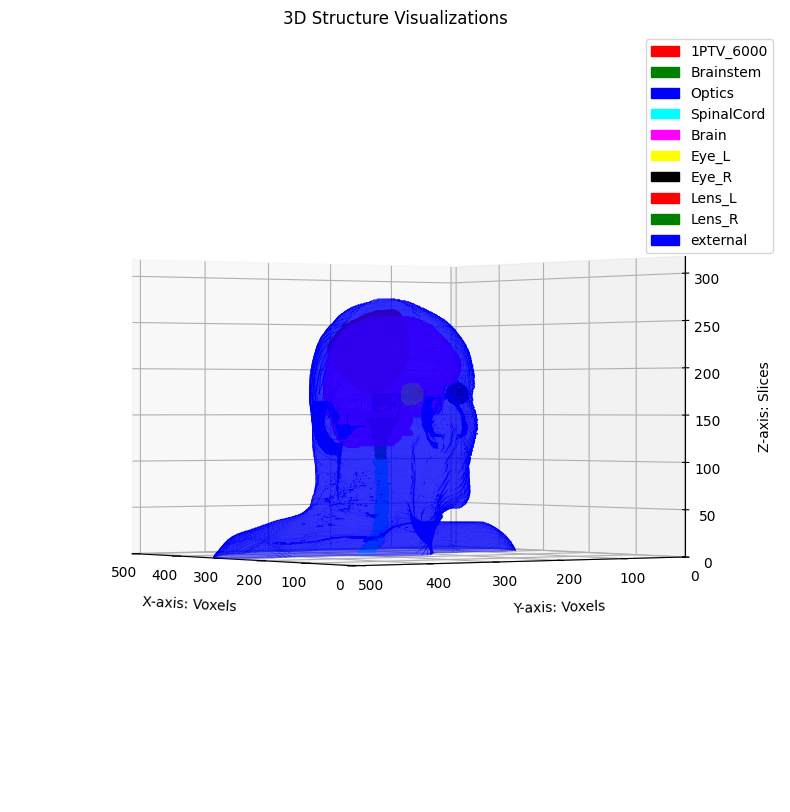

In [50]:
# Create dictionary of ROI names and numbers from structure file
ROI_Names = {ROI.ROINumber: ROI.ROIName for ROI in RS_Files[0].StructureSetROISequence}

# Define structures of interest to the user. Need to consult ROI_Names to do this
# Target_Structures = ["1GTV3000", "1PTV3000", "SpinalCord", "Brain", "Eye_L", "Eye_R"]
# Target_Structures = ["1PTV3000"]
# Target_Structures = ["PTV1_3000", "BrainStem", "Eye_L", "Eye_R", "Optics", "Lens_L", "Lens_R", "Optic Chiasm"]
# Target_Structures = ["PTV_6000", "Brain", "SpinalCanal", "Optics", "Eye_L", "Eye_R", "Lens_L", "Lens_R"]
Target_Structures = ["1PTV_6000", "Brainstem", "Optics", "SpinalCord", "Brain", "Eye_L", "Eye_R", "Lens_L", "Lens_R", "external"]
# Target_Structures = ["Brain"]
Target_Numbers = np.full(len(Target_Structures), np.nan) # pre-allocate Target_Numbers

# Fill in Target_Numbers
for i, structure in enumerate(Target_Structures): # loop through every structure name of interest
    for Number, Name in ROI_Names.items(): # loop through dictionary until there is a match
        if structure.upper() == Name.upper():
            Target_Numbers[i] = Number
            break

# Create a 3d plot for visualization
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection = '3d')

# Define colours array
colours = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black']

# Define contour sequence
Contour_Sequence = RS_Files[0].ROIContourSequence

# Pre-allocate to contain all masks
all_masks = []

# Get contour data from every target structure, by verifying ROI number
for i, Number in enumerate(Target_Numbers):
    for ROI in Contour_Sequence:
        if ROI.ReferencedROINumber == Number:
            Contour_Data = ROI.ContourSequence
            break

    # Get contour points and make 3D mask
    # contour_points = np.array([]).reshape(0,3) # pre-allocate matrix of all contour points
    mask = np.zeros(CT_Images[:, :, :].shape) # pre-allocate mask
    for Contour in Contour_Data: # get the contour points in every slice
        contour_points_mm = np.array(Contour.ContourData).reshape(-1, 3) # (n, 3) 3 columns in n rows. in mm
        contour_points_slice = np.array([mm_to_voxel(p, origin, voxel_spacing) for p in contour_points_mm])
        rr, cc = polygon(contour_points_slice[:,1], contour_points_slice[:,0], CT_Images[:, :, 0].shape)
        mask[rr, cc, contour_points_slice[0,2]] = 1

    # Extract surface mesh with marching cubes
    verts, faces, normals, values = measure.marching_cubes(mask, level=0.5) 

    # Append masks to all_masks variable
    all_masks.append(mask)
    
    # Create mesh (collection of triangles?) from vertices and faces
    mesh = Poly3DCollection(verts[faces], alpha = 0.7)
    mesh.set_facecolor(colours[i % len(colours)])
    ax.add_collection3d(mesh)


# Set labels and axis limits
ax.set_xlabel("X-axis: Voxels", labelpad=20)
ax.set_ylabel("Y-axis: Voxels", labelpad=20)
ax.set_zlabel("Z-axis: Slices", labelpad=20)
ax.set_title("3D Structure Visualizations")
ax.set_xlim(0, mask.shape[0])
ax.set_ylim(0, mask.shape[1])
ax.set_zlim(0, mask.shape[2])

# Create a legend
legend_patches = [
    mpatches.Patch(color=colours[i % len(colours)], label=Target_Structures[i])
    for i in range(len(Target_Structures))
]
ax.legend(handles = legend_patches, loc = 'upper right')

# Change zoom (let's us see z-axis label)
ax.set_box_aspect(aspect=None, zoom=0.8)

# Change viewing angle
ax.view_init(0, 145) # elevation, azimuth

plt.show()

### Align 3D dose volume with the CT coordinates

#### Interpolation Method

In [55]:
# Defining stuff

Sorted_CT_Files = sorted(CT_Files, key=lambda file: float(file.ImagePositionPatient[2])) # sort files by z-axis. increasing towards the head
# anatomical orientation type (0010,2210) absent so z-axis is increasing towards the head of the patient

CT_Images = np.stack([slice.pixel_array for slice in Sorted_CT_Files], axis = 2) # make 3d matrix in [y x z]
CT_Images = np.transpose(CT_Images, (1, 0, 2)) # make it [x y z]

pixel_spacing = Sorted_CT_Files[0].PixelSpacing # pixel spacing in mm, [y x]
slice_thickness = Sorted_CT_Files[0].SliceThickness # slice thickness in mm [z]
voxel_spacing = np.array([pixel_spacing[1], pixel_spacing[0], slice_thickness]) # [x y z]
origin = np.array(Sorted_CT_Files[0].ImagePositionPatient) # origin in mm [x y z]

# First define stuff from dose

# Find which dose file is the "PLAN" so the total dose
for i in range(len(RD_Files)):
    if RD_Files[i].DoseSummationType.upper() == "PLAN":
        plan_dose = i
        break

# Define some parameters from the dose file(s)
dose_origin = RD_Files[0].ImagePositionPatient # Origin for the dose files. All have the same origin
dose_pixel_spacing = RD_Files[0].PixelSpacing # Pixel spacing for the dose files. All have the same spacing. In mm. [y x]
dose_slice_thickness = RD_Files[0].SliceThickness # Slice thickness for the dose files. All have the same thickness. In mm. [z]
dose_voxel_spacing = np.array([dose_pixel_spacing[1], dose_pixel_spacing[0], dose_slice_thickness]) # Voxel spacing for the dose files. [x y z]
dose_images = np.transpose(RD_Files[plan_dose].pixel_array, (2, 1, 0)) # Take dose array and make it [x y z]. Starts off as [z y x]

# Define isocentre
Isocentre_Pos = np.array(RP_Files[0].BeamSequence[0].ControlPointSequence[0].IsocenterPosition) # get isocentre position in mm [x y z]
Isocentre_Pos = np.round((Isocentre_Pos - origin)/voxel_spacing).astype(int) # get isocentre in terms of voxels

In [60]:
# Get masks/contours

# Create dictionary of ROI names and numbers from structure file
ROI_Names = {ROI.ROINumber: ROI.ROIName for ROI in RS_Files[0].StructureSetROISequence}

# Define structures of interest to the user. Need to consult ROI_Names to do this
# Target_Structures = ["1GTV3000", "1PTV3000", "SpinalCord", "Brain", "Eye_L", "Eye_R"]
# Target_Structures = ["1PTV3000"]
# Target_Structures = ["PTV1_3000", "BrainStem", "Eye_L", "Eye_R", "Optics", "Lens_L", "Lens_R", "Optic Chiasm"]
# Target_Structures = ["PTV_6000", "Brain", "SpinalCanal", "Optics", "Eye_L", "Eye_R", "Lens_L", "Lens_R"]
Target_Structures = ["1PTV_6000", "Brainstem", "Optics", "SpinalCord", "Brain", "Eye_L", "Eye_R", "Lens_L", "Lens_R"]
# Target_Structures = ["1PTV_6000"]

Target_Numbers = np.full(len(Target_Structures), np.nan) # pre-allocate Target_Numbers

# Fill in Target_Numbers
for i, structure in enumerate(Target_Structures): # loop through every structure name of interest
    for Number, Name in ROI_Names.items(): # loop through dictionary until there is a match
        if structure.upper() == Name.upper():
            Target_Numbers[i] = Number
            break

# Define contour sequence
Contour_Sequence = RS_Files[0].ROIContourSequence

# Pre-allocate something to contain all masks
all_masks = []

# Get contour data from every target structure, by verifying ROI number
for i, Number in enumerate(Target_Numbers):
    for ROI in Contour_Sequence:
        if ROI.ReferencedROINumber == Number:
            Contour_Data = ROI.ContourSequence
            break

    # Get contour points and make 3D mask
    mask = np.zeros(CT_Images[:, :, :].shape) # pre-allocate mask
    for Contour in Contour_Data: # get the contour points in every slice
        contour_points_mm = np.array(Contour.ContourData).reshape(-1, 3) # (n, 3) 3 columns in n rows. in mm
        contour_points_slice = np.array([mm_to_voxel(p, origin, voxel_spacing) for p in contour_points_mm])
        # Generates 0s and 1s of all the points within the shape of the contour
        rr, cc = polygon(contour_points_slice[:,1], contour_points_slice[:,0], CT_Images[:, :, 0].shape)
        mask[cc, rr, contour_points_slice[0,2]] = 1

    # Append masks to all_masks variable
    all_masks.append(mask.astype(bool))

In [61]:
# Trying now with the interpolate method

# Need to interpolate from dose to shape it towards ct scan

# Get grid for x, y, z from the ct mask in mm to make a an array of every possible point
z = np.arange(len(CT_Files)) * voxel_spacing[2] + origin[2] # z
y = np.arange(512) * voxel_spacing[1] + origin[1] # y
x = np.arange(512) * voxel_spacing[0] + origin[0] # x
X, Y, Z = np.meshgrid(x, y, z, indexing = 'ij')
points = np.stack((X.flatten(), Y.flatten(), Z.flatten()), axis = -1) # makes array of every possible point in [x y z]

# Get the dose points in mm for x, y, z
dose_z = np.arange(dose_images.shape[2]) * dose_voxel_spacing[2] + dose_origin[2]
dose_y = np.arange(dose_images.shape[1]) * dose_voxel_spacing[1] + dose_origin[1]
dose_x = np.arange(dose_images.shape[0]) * dose_voxel_spacing[0] + dose_origin[0]

# Define interpolating function. Bounds_error false so we can go outside of the bounds and fill_value is 0 so outside of bounds is 0
interpolator = RegularGridInterpolator((dose_x, dose_y, dose_z), dose_images, bounds_error = False, fill_value = 0)

# Fit dose to 512 x 512 x 464 grid (same as CT image/mas shape)
dose_resampled = interpolator(points).reshape(CT_Images.shape)

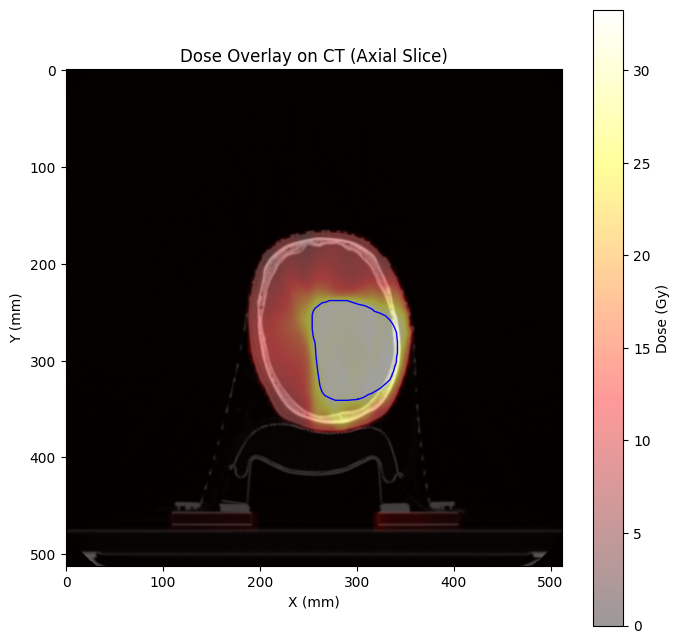

In [62]:
# Define CT voxel centre from isocentre
# From this dose centre find corresponding CT voxel coordinates
ct_voxel_centre = Isocentre_Pos

# Find slice index and corresponding CT image characteristics for that slice
slice_index = ct_voxel_centre[2]
ct_slice = CT_Images[:, :, slice_index]

dose_slice_resampled = dose_resampled[:, :, slice_index] # same slice index as ct_slice

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(ct_slice.T, cmap='gray', origin='upper', alpha=1.0)
plt.imshow(dose_slice_resampled.T * RD_Files[plan_dose].DoseGridScaling, cmap='hot', origin='upper', alpha=0.4)
# plt.imshow(dose_slice.T/1000, cmap='hot', origin='upper', alpha=0.4)
# plt.imshow(ct_slice.T, cmap='gray', origin='upper', alpha=1.0)
plt.title("Dose Overlay on CT (Axial Slice)")
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.colorbar(label="Dose (Gy)")

contour_axial = contour_points[slice_index == contour_points[:, 2]] # collect points when on same slice as this figure
x_pts, y_pts = contour_axial[:, 0], contour_axial[:, 1]
# For axial axis add the first points to the end of x_pts and y_pts so that the line closes properly
x_pts = np.append(x_pts, contour_axial[0, 0])
y_pts = np.append(y_pts, contour_axial[0, 1])
plt.plot(x_pts, y_pts, 'b-', linewidth = 1)

plt.show()

### Dose-Volume-Histogram

In [5]:
# Defining stuff

Sorted_CT_Files = sorted(CT_Files, key=lambda file: float(file.ImagePositionPatient[2])) # sort files by z-axis. increasing towards the head
# anatomical orientation type (0010,2210) absent so z-axis is increasing towards the head of the patient

CT_Images = np.stack([slice.pixel_array for slice in Sorted_CT_Files], axis = 2) # make 3d matrix in [y x z]
CT_Images = np.transpose(CT_Images, (1, 0, 2)) # make it [x y z]

pixel_spacing = Sorted_CT_Files[0].PixelSpacing # pixel spacing in mm, [y x]
slice_thickness = Sorted_CT_Files[0].SliceThickness # slice thickness in mm [z]
voxel_spacing = np.array([pixel_spacing[1], pixel_spacing[0], slice_thickness]) # [x y z]
origin = np.array(Sorted_CT_Files[0].ImagePositionPatient) # origin in mm [x y z]

# First define stuff from dose

# Find which dose file is the "PLAN" so the total dose
for i in range(len(RD_Files)):
    if RD_Files[i].DoseSummationType.upper() == "PLAN":
        plan_dose = i
        break

# Define some parameters from the dose file(s)
dose_origin = RD_Files[0].ImagePositionPatient # Origin for the dose files. All have the same origin
dose_pixel_spacing = RD_Files[0].PixelSpacing # Pixel spacing for the dose files. All have the same spacing. In mm. [y x]
dose_slice_thickness = RD_Files[0].SliceThickness # Slice thickness for the dose files. All have the same thickness. In mm. [z]
dose_voxel_spacing = np.array([dose_pixel_spacing[1], dose_pixel_spacing[0], dose_slice_thickness]) # Voxel spacing for the dose files. [x y z]
dose_images = np.transpose(RD_Files[plan_dose].pixel_array, (2, 1, 0)) # Take dose array and make it [x y z]. Starts off as [z y x]

In [6]:
# Get masks

# Create dictionary of ROI names and numbers from structure file
ROI_Names = {ROI.ROINumber: ROI.ROIName for ROI in RS_Files[0].StructureSetROISequence}

# Define structures of interest to the user. Need to consult ROI_Names to do this
# Target_Structures = ["1GTV3000", "1PTV3000", "SpinalCord", "Brain", "Eye_L", "Eye_R"]
# Target_Structures = ["1PTV3000"]
# Target_Structures = ["PTV1_3000", "BrainStem", "Eye_L", "Eye_R", "Optics", "Lens_L", "Lens_R", "Optic Chiasm"]
# Target_Structures = ["PTV1_3000", "BrainStem", "Optics", "Optic Chiasm"]
# Target_Structures = ["PTV1_3000"]
# Target_Structures = ["PTV_6000", "Brain", "SpinalCanal", "Optics", "Eye_L", "Eye_R", "Lens_L", "Lens_R"]
Target_Structures = ["1PTV_6000", "Brainstem", "Optics", "SpinalCord", "Brain", "Eye_L", "Eye_R", "Lens_L", "Lens_R"]
Target_Numbers = np.full(len(Target_Structures), np.nan) # pre-allocate Target_Numbers

# Fill in Target_Numbers
for i, structure in enumerate(Target_Structures): # loop through every structure name of interest
    for Number, Name in ROI_Names.items(): # loop through dictionary until there is a match
        if structure.upper() == Name.upper():
            Target_Numbers[i] = Number
            break

# Define contour sequence
Contour_Sequence = RS_Files[0].ROIContourSequence

# Pre-allocate something to contain all masks
all_masks = []

# Get contour data from every target structure, by verifying ROI number
for i, Number in enumerate(Target_Numbers):
    for ROI in Contour_Sequence:
        if ROI.ReferencedROINumber == Number:
            Contour_Data = ROI.ContourSequence
            break

    # Get contour points and make 3D mask
    mask = np.zeros(CT_Images[:, :, :].shape) # pre-allocate mask
    for Contour in Contour_Data: # get the contour points in every slice
        contour_points_mm = np.array(Contour.ContourData).reshape(-1, 3) # (n, 3) 3 columns in n rows. in mm
        contour_points_slice = np.array([mm_to_voxel(p, origin, voxel_spacing) for p in contour_points_mm])
        rr, cc = polygon(contour_points_slice[:,1], contour_points_slice[:,0], CT_Images[:, :, 0].shape)
        mask[cc, rr, contour_points_slice[0,2]] = 1

    # Append masks to all_masks variable
    all_masks.append(mask.astype(bool))


In [10]:
# Interpolating from CT_images shape to dose_image shape

# Get grid for x, y, z from the ct mask in mm to make a an array of every possible point
z = np.arange(mask.shape[2]) * voxel_spacing[2] + origin[2]
y = np.arange(mask.shape[1]) * voxel_spacing[1] + origin[1]
x = np.arange(mask.shape[0]) * voxel_spacing[0] + origin[0]

# Get the dose points in mm for x, y, z
dose_z = np.arange(dose_images.shape[2]) * dose_voxel_spacing[2] + dose_origin[2]
dose_y = np.arange(dose_images.shape[1]) * dose_voxel_spacing[1] + dose_origin[1]
dose_x = np.arange(dose_images.shape[0]) * dose_voxel_spacing[0] + dose_origin[0]
X, Y, Z = np.meshgrid(dose_x, dose_y, dose_z, indexing='ij')
points = np.stack((X.flatten(), Y.flatten(), Z.flatten()), axis = -1) # makes array of every possible point in [x y z] for dose shape

all_masks_resampled = []
# Fit all the masks to dose image shape
for mask in all_masks:
    interpolator = RegularGridInterpolator((x, y, z), mask, bounds_error = False, fill_value = 0)
    mask_resampled = interpolator(points).reshape(dose_images.shape).astype(bool)
    all_masks_resampled.append(mask_resampled)

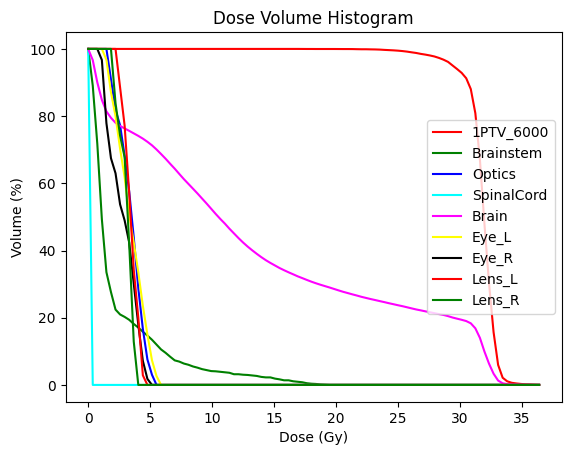

In [13]:
# Define colours array
colours = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black']

for i, mask in enumerate(all_masks_resampled):
    # When mask is true, then get how much dose hits there. So how much dose hits that structure
    structure_dose_values = dose_images[mask.astype(bool)]

    # Get "histogram" of stuff in bins
    counts, bin_edges = np.histogram(structure_dose_values, bins = 100, range = (0, np.max(dose_images)))

    cumulative = np.cumsum(counts[::-1])[::-1] # Cumulative dose. Number of voxels receiving >= to a dose (from bin_edges)
    volume_cum = cumulative*100/counts.sum() # Cumulative dose

    bin_edges = bin_edges[:-1] * RD_Files[plan_dose].DoseGridScaling # exclude last max value and convert to Gy

    plt.plot(bin_edges, volume_cum, '-', label = Target_Structures[i], color = colours[i % len(colours)])

plt.legend()
plt.xlabel("Dose (Gy)")
plt.ylabel("Volume (%)")
plt.title("Dose Volume Histogram")
plt.show()